Code to correct the aberration mainly introcuded by the R11 SLM. This work is based on Mark Neil's Matlab code:`startestWFSnew.m`. A Thorlabs scientific camera(CS2100M-USB) is used to obtain PSF images.

In [2]:
import sys
print(sys.path)

['C:\\Users\\ML2618\\PycharmProjects\\HexSimInstrument', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\python38.zip', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\DLLs', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib', '', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib\\site-packages', 'C:\\Users\\ML2618\\PycharmProjects\\napari-pcd-reader_draft\\src', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib\\site-packages\\win32', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib\\site-packages\\win32\\lib', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib\\site-packages\\Pythonwin']


In [3]:
import numpy as np
import cupy as cp
import scipy.ndimage
import matplotlib.pyplot as plt
import time
from IPython import display
from pylablib.devices import Thorlabs
import ctypes as ct
from random import randrange
import subprocess, os
import scipy.ndimage
import cupyx.scipy.ndimage as cpndimage

In [4]:
xp = cp
n_bias = 3

In [5]:
print(f'Cameras attached: {Thorlabs.list_cameras_tlcam()}')
cam = Thorlabs.ThorlabsTLCamera()

Cameras attached: ['14403']


In [29]:
cam.close()
slm.deactivate()
slm.close()

Port closed successfully


In [7]:
class Dev(ct.Structure):
    pass
Dev._fields_ = [("id", ct.c_char_p), ("next", ct.POINTER(Dev))]
                
                
class SLMDev():
    """
    Connect to the real-world Methods allow for device read and write functions for R11 SLM.
    """

    def __init__(self):

        self.NULL = ct.POINTER(ct.c_int)()
        self.RS485_DEV_TIMEOUT = ct.c_uint16(1000)
        self.r11 = ct.windll.LoadLibrary('C:/Program Files/MetroCon-4.1/R11CommLib-1.8-x64.dll')
        self.xpix = 2048
        self.ypix = 2048
        self.xv, self.yv = self.interleaving()
        
    def initiate(self):
        ver = ct.create_string_buffer(8)
        maxlen = ct.c_uint8(10)
        res = self.r11.R11_LibGetVersion(ver, maxlen)
        if (res == 0):
            print('Software version: %s' % ver.value)
        else:
            raise Exception('Libarary not loaded')
        guid = ct.c_char_p(b"54ED7AC9-CC23-4165-BE32-79016BAFB950")
        devcount = ct.c_uint16(0)
        devlist = ct.POINTER(Dev)()
        res = self.r11.FDD_DevEnumerateWinUSB(guid, ct.pointer(devlist), ct.byref(devcount))
        if res == 0:
            port = devlist.contents.id.decode()
            print('Dev port: %s' % port)
        else:
            raise Exception('Cannot find the port')

    def open_usb_port(self):
        port = ct.c_char_p(b'\\\\?\\usb#vid_19ec&pid_0503#0175000881#{54ed7ac9-cc23-4165-be32-79016bafb950}')
        re = self.r11.FDD_DevOpenWinUSB(port, self.RS485_DEV_TIMEOUT)
        if re == 0:
            print('Open Dev port successfully')
            dispTemp = ct.c_uint16(0)
            self.r11.R11_RpcSysGetDisplayTemp(ct.byref(dispTemp))
            print('Display temperature: %s' % dispTemp.value)
        else:
            raise Exception(' Fail to open the port ')

    def activate(self,):
        res = self.r11.R11_RpcRoActivate(ct.c_void_p())
        if res != 0:
            raise Exception(f'Fail to activate SLM. Error code: {res}')

    def deactivate(self):
        res = self.r11.R11_RpcRoDeactivate(ct.c_void_p())
        if res != 0:
            raise Exception(f'Fail to deactivate. Error code: {res}')

    def getordernum(self):
        rocount = ct.c_uint16(0)
        res = self.r11.R11_RpcRoGetCount(ct.byref(rocount))
        if res == 0:
            num = rocount.value
            print('order number: %s' % num)
        else:
            raise Exception('Fail to get the order number')

    def getActivationType(self):
        """Retrieve the activation typr of the currently loaded running order"""
        actType = ct.c_uint8(0)
        res = self.r11.R11_RpcRoGetActivationType(ct.byref(actType))
        if res == 0:
            return actType.value
        else:
            raise Exception('Failed to get activation type')

    def getRO(self):
        roindex = ct.c_uint16(0)
        res_index = self.r11.R11_RpcRoGetSelected(ct.byref(roindex))
        roName = ct.create_string_buffer(255)
        res_name = self.r11.R11_RpcRoGetName(roindex, roName, len(roName))
        if (res_index == 0) & (res_name == 0):
            return roindex.value, roName.value
        elif res_index != 0:
            raise Exception('Failed to get RO index')
        elif res_name != 0:
            raise Exception('Failed to get RO name')

    def getRepName(self):
        """Retrieve the name of the repertoire loaded on the board."""
        repName = ct.create_string_buffer(255)
        re = self.r11.R11_RpcSysGetRepertoireName(repName, len(repName))
        if re == 0:
            return repName.value
        else:
            raise Exception('Failed to get repertoire name')

    def setRO(self, n):
        roindex = ct.c_uint16(n)
        res = self.r11.R11_RpcRoSetSelected(roindex)
        if res == 0:
            num = roindex.value
            print(f'Order is set to {num}')
        else:
            raise Exception('Failed to set the order')

    def getState(self):
        actState = ct.c_uint8(0)
        self.r11.R11_RpcRoGetActivationState(ct.byref(actState))
        return actState.value

    def close(self):
        res = self.r11.FDD_DevClose()
        if res == 0:
            print('Port closed successfully')
        else:
            raise Exception('Fail to closE R11 SLM')

    def interleaving(self):
        x0 = xp.zeros(self.xpix)
        y0 = xp.arange(self.ypix)

        nr = xp.arange(8)
        for i in range(64):
            x0[(i * 32):(i * 32 + 8)] = nr + i * 8
            x0[(i * 32 + 8):(i * 32 + 16)] = nr + i * 8 + 512
            x0[(i * 32 + 16):(i * 32 + 24)] = nr + i * 8 + 1024
            x0[(i * 32 + 24):(i * 32 + 32)] = nr + i * 8 + 1536
        # x0 is now an array of interleaved x values in the correct places for sending to the SLM

        x, y = xp.meshgrid(x0, y0)
        return x, y

    def sendBitplane(self, data, frameno):
        print(f'sending frame number {frameno}')
        t0 = time.time()
        for block in range(4):
            block_address = 0x01000000 + block * 64 + frameno * 256
            # Flash blocks per bitplane: 4
            # Flash pages per bitplane: 256
            res = self.r11.R11_RpcFlashEraseBlock(ct.c_uint32(block_address))
            if res != 0:
                raise Exception(f'Fail to erase block {block}')
            for page in range(64):
                buf = np.uint8(data[(block * 64 + page) * 2048:(block * 64 + page) * 2048 + 2048])
                res = self.r11.R11_FlashWrite(buf.ctypes.data_as(ct.POINTER(ct.c_uint8)), ct.c_uint16(0),
                                              ct.c_uint16(2048))
                if res != 0:
                    raise Exception(f'Fail write block {block}: page {page}')
                page_address = ct.c_uint32(block_address + page)
                res = self.r11.R11_FlashBurn(page_address)
                if res != 0:
                    raise Exception(f'Fail burn block {block}: page {page}')
        print(f'bitplane sent in {time.time() - t0}')
        
    def sendBitplaneByte(self, data, frameno):
        print(f'sending frame number {frameno} to {frameno + 7}')
        t0 = time.time()
        for f in range(8):
            for block in range(4 + f):
                block_address = 0x01000000 + block * 64 + (frameno + f) * 256
                # Flash blocks per bitplane: 4
                # Flash pages per bitplane: 256
                res = self.r11.R11_RpcFlashEraseBlock(ct.c_uint32(block_address))
                if res != 0:
                    raise Exception(f'Fail to erase block {block}')
                for page in range(64):
                    buf = np.uint8(data[(block * 64 + page) * 2048:(block * 64 + page) * 2048 + 2048])
                    res = self.r11.R11_FlashWrite(buf.ctypes.data_as(ct.POINTER(ct.c_uint8)), ct.c_uint16(0),
                                                  ct.c_uint16(2048))
                    if res != 0:
                        raise Exception(f'Fail write block {block}: page {page}')
                    page_address = ct.c_uint32(block_address + page)
                    res = self.r11.R11_FlashBurn(page_address)
                    if res != 0:
                        raise Exception(f'Fail burn block {block}: page {page}')
        print(f'bitplane sent in {time.time() - t0}')

    def eraseBitplane(self, frameno):
        for block in range(4):
            block_address = 0x01000000 + block * 64 + frameno * 256

            res = self.r11.R11_RpcFlashEraseBlock(ct.c_uint32(block_address))
        if res == 0:
            print(f'Frame number {frameno} erased')
        else:
            raise Exception(f'Fail to erase block {block}')

    def repReload(self):
        res = self.r11.R11_RpcSysReloadRepertoire()
        t0 = time.time()
        while self.getProgress() != 100:
            self.getProgress()
        t = time.time() - t0
        print(f'Elapsed time of reloading: {t}')
        if res != 0:
            raise Exception('Fail reload repertoire')

    def getProgress(self):
        """Get the progress of the current board operation."""
        p = ct.c_uint8(0)
        res = self.r11.R11_DevGetProgress(ct.byref(p))
        if res != 0:
            raise Exception(f'Fail to get progress. Error code: {res}')
        return p.value

## SLM's hardware functions

In [8]:
class SLMHar():
    """class to control the SLM hardware"""
    BPins = [None] * n_bias

    def flashCorrection(self, img):
        randImg = randrange(11, 768 - n_bias)
        for i in range(n_bias):
            self.BPins[i] = randImg + i  # bit planes index
        for k in range(n_bias):
            slm.sendBitplane(img[k], self.BPins[k])

            
    def writeCorrRep(self, fns, imgns='hol.png'):
        """write a text file of the SLM correction repertoire and save it as '.rep' format,and then build it to a '.repz11' file."""
        os.chdir('C:/Users/ML2618/Desktop/SLMtests')
        with open(f'{fns}.txt', 'w') as f:
            data = ("ID\n"
                    '"V1.0 ${date(\\"yyyy-MMM-dd HH:mm:ss\\")}"\n'
                    "ID_END\n\n"
                    "PLATFORM\n"
                    '"R11"\n'
                    "PLATFORM_END\n\n"
                    "DISPLAY\n"
                    '"2Kx2K"\n'
                    "DISPLAY_END\n\n"
                    "FORMATVERSION\n"
                    '"FV4"\n'
                    "FORMATVERSION_END\n\n"
                    "SEQUENCES\n")
            f.write(data)

            data2 = ('A "48160 1ms 1-bit Balanced.seq11"\n'
                     'SEQUENCES_END\n\n'
                     'IMAGES\n')
            f.write(data2)

            for i in range(n_bias):
                data3 =(f' 1 "{imgns}"\n')
                f.write(data3)

            data4 = ('IMAGES_END\n'
                     f'DEFAULT "R0{self.BPins[0]}"\n'
                    '[HWA \n'
                    f'<(A, {self.BPins[0]}) >\n'
                    ']\n')
            f.write(data4)
            
            for k in range(1, n_bias):
                data5 = (f'"R0{self.BPins[k]}"\n'
                    '[HWA \n'
                    f'<(A, {self.BPins[k]}) >\n'
                    ']\n')
    
                f.write(data5)

        os.rename(f'{fns}.txt', f'{fns}.rep')
        print('New rep file created')

        # build the rep to a repz11 file
        print(os.getcwd())
        output = subprocess.run(['RepBuild', fns + '.rep', '-c', fns + '.repz11'], shell=True,
                                stdout=subprocess.PIPE)
        if output.returncode == 0:
            print(output.stdout.decode())
            print('repz11 file created')
        else:
            print(f'rep to repz11 failed, error: {output.stderr}')
#         print(os.getcwd())
        
    def writeCorrRepByte(self, fns, imgns='hol8.png'):
        """write a text file of the SLM correction repertoire and save it as '.rep' format,and then build it to a '.repz11' file."""
        os.chdir('C:/Users/ML2618/Desktop/SLMtests')
        with open(f'{fns}.txt', 'w') as f:
            data = ("ID\n"
                    '"V1.0 ${date(\\"yyyy-MMM-dd HH:mm:ss\\")}"\n'
                    "ID_END\n\n"
                    "PLATFORM\n"
                    '"R11"\n'
                    "PLATFORM_END\n\n"
                    "DISPLAY\n"
                    '"2Kx2K"\n'
                    "DISPLAY_END\n\n"
                    "FORMATVERSION\n"
                    '"FV4"\n'
                    "FORMATVERSION_END\n\n"
                    "SEQUENCES\n")
            f.write(data)

            data2 = ('A "48111 1.5ms 8-bit Balanced.seq11"\n'
                     'SEQUENCES_END\n\n'
                     'IMAGES\n')
            f.write(data2)

            for i in range(3):
                data3 =(f' 8 "{imgns}"\n')
                f.write(data3)

            data4 = ('IMAGES_END\n'
                     f'DEFAULT "8bit"\n'
                    '[HWA \n'
                    f'<(A, {BPins}) >\n'
                    ']\n'
                    )
            f.write(data4)

        os.rename(f'{fns}.txt', f'{fns}.rep')
        print('New rep file created')

        # build the rep to a repz11 file
        print(os.getcwd())
        output = subprocess.run(['RepBuild', fns + '.rep', '-c', fns + '.repz11'], shell=True,
                                stdout=subprocess.PIPE)
        if output.returncode == 0:
            print(output.stdout.decode())
            print('repz11 file created')
        else:
            print(f'rep to repz11 failed, error: {output.stderr}')
        print(os.getcwd())
    #     os.chdir('..')
    
    
    
    
    def repSendBP(self, fn):
        """Send the repz.11 file to the board. fn: file name, e.g. 'test1'"""
        slm.close()
    #     os.chdir('./gen_repertoires')
        output = subprocess.run(['RepSender', '-z', fn, '-d', '0175000881', '-i'], shell=True, stdout=subprocess.PIPE)
        if output.returncode == 0:
            print('New repertoire sent without images.')
        else:
            print(f'Repertoire sending without images failed, error: {output.stderr}')
    #     os.chdir('..')
        slm.open_usb_port()
        
    def updateBp(self, img, fn):
        t0 = time.time()
        self.flashCorrection(img)
        self.writeCorrRep(fn)
        self.repSendBP(fn +'.repz11')
        print(f'Repertoire updated in {time.time() - t0}s')

In [9]:
slm = SLMDev()
slm.initiate()
slm.open_usb_port()

Software version: b'1.8.189.'
Dev port: \\?\usb#vid_19ec&pid_0503#0175000881#{54ed7ac9-cc23-4165-be32-79016bafb950}:0175000881
Open Dev port successfully
Display temperature: 9936


In [10]:
har = SLMHar()

## Camera functions

Live camera viewing.

In [10]:
# cam.set_exposure(0.001)
# cam.set_roi(hstart=0, hend=None, vstart=0, vend=None, hbin=1, vbin=1)
# fig, ax = plt.subplots(figsize=(20,20))
# tc0 = time.time()
# while time.time() - tc0 < 3:
#     frame = cam.snap()
#     ax.clear()
#     ax.imshow(frame)
#     display.clear_output(wait=True)
#     display.display(ax.get_figure())
#     plt.pause(0.1)

In [164]:
slm.setRO(0)

Order is set to 0


In [606]:
slm.deactivate()

In [12]:
cam.open()

Checking the ROI.

(256, 256)


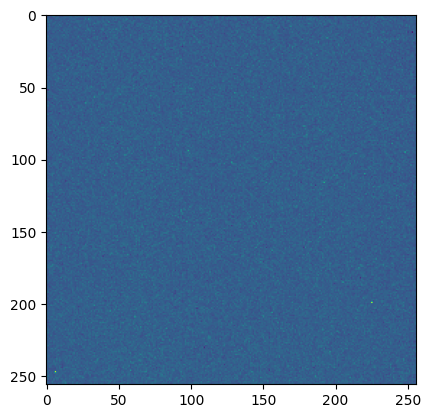

In [13]:
cam.set_exposure(0.01)
# cam.set_roi(hstart=968, hend=1224, vstart=319, vend=575, hbin=1, vbin=1)
cam.set_roi(hstart=562, hend=818, vstart=207, vend=463, hbin=1, vbin=1)
ri = cam.snap()
plt.imshow(ri)
print(ri.shape)

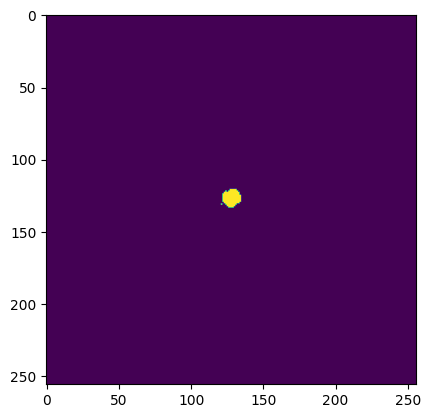

In [137]:
plt.imshow(ri > 2500)

Chcking the full screen.

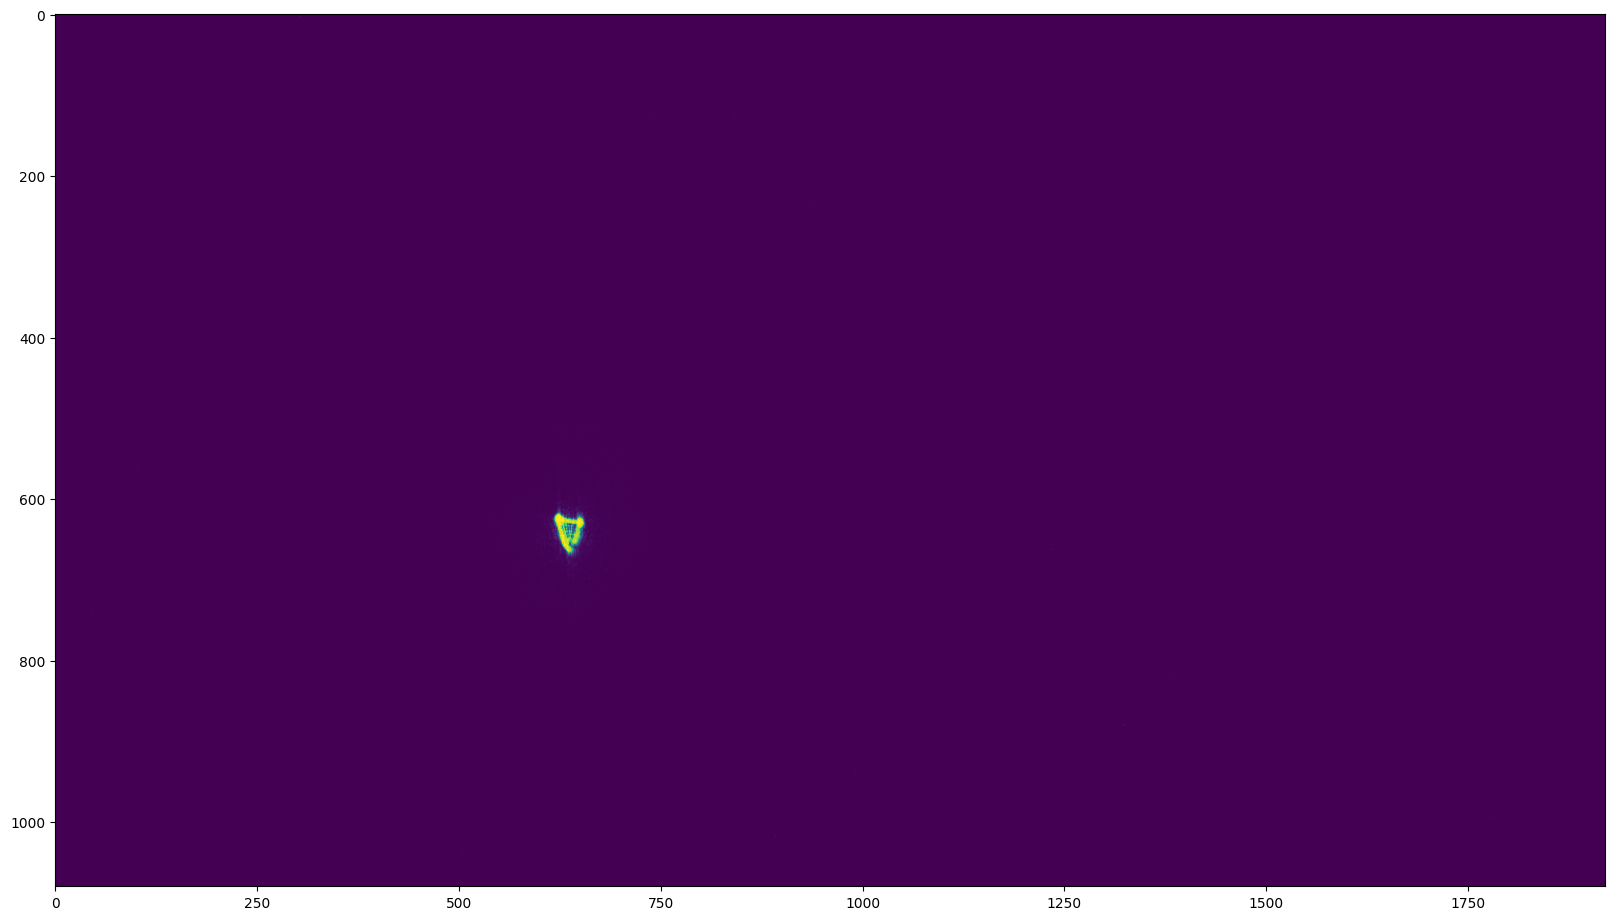

In [12]:
cam.set_exposure(0.1)
cam.set_roi(hstart=0, hend=None, vstart=0, vend=None, hbin=1, vbin=1)
ri = cam.snap()
plt.figure(figsize=(20,20))
plt.imshow(ri)

# Aberration correction simulation

In [14]:
# titles = ['Guess for PSF intensity', 'Phase sum in pupil', 'Phase difference in pupil', 'Amplitude in pupil', 'Amplitude profile in pupil', 'Unwrapped PSF phase', 'Unwrapped PSF phase difference', 'Simulated phase aberration', 'Simulated phase aberration sum', 'Measured PSF', 'Measured PSF+defocus', 'Measured PSF-defocus'
titles = ['Guess for PSF intensity', 'Phase sum in pupil', 'Phase difference in pupil', 'Amplitude in pupil', 'Amplitude profile in pupil', 'Unwrapped PSF phase', 'Zernike fitted phase', 'Simulated phase aberration', 'Simulated phase aberration sum', 'Measured PSF', 'Measured PSF+defocus', 'Measured PSF-defocus']

Set up arrays

In [15]:
N = 128
MAG = 1.085
x, y = xp.meshgrid(xp.linspace(-MAG, MAG, N), xp.linspace(-MAG, MAG, N))
r = xp.sqrt(x ** 2 + y ** 2)
theta = xp.arctan2(y, x)
circ = r < 1
normval = xp.sum(circ)

Zernike aberrations

In [16]:
Z00 = xp.ones_like(x) * circ
Z11 = 2 * r * xp.cos(theta) * circ
Z1_1 = 2 * r * xp.sin(theta) *circ
Z20 = xp.sqrt(3) * (2 * r ** 2 - 1) * circ
Z22 = xp.sqrt(6) * r ** 2 * xp.cos(2 * theta) * circ
Z2_2 = xp.sqrt(6) * r ** 2 * xp.sin(2 * theta) * circ
Z31 = 2 * xp.sqrt(2) * (3 * r ** 3 - 2 * r) * xp.cos(theta) * circ
Z3_1 = 2 * xp.sqrt(2) * (3 * r ** 3 - 2 * r) * xp.sin(theta) * circ
Z33 = 2 * xp.sqrt(2) * r ** 3 * xp.cos(3 * theta) * circ
Z3_3 = 2 * xp.sqrt(2) * r ** 3 * xp.sin(3 * theta) * circ
Z40 = xp.sqrt(5) * (6 * r ** 4 - 6 * r ** 2 + 1) * circ
Z42 = xp.sqrt(10) * (4 * r ** 4 - 3 * r ** 2) * xp.cos(2 * theta) * circ
Z4_2 = xp.sqrt(10) * (4 * r ** 4 - 3 * r ** 2) * xp.sin(2 * theta) * circ
Z44 = xp.sqrt(10) * r ** 4 * xp.cos(4 * theta) * circ
Z4_4 = xp.sqrt(10) * r ** 4 * xp.sin(4 * theta) * circ
Z51 = 2 * xp.sqrt(3) * (10 * r ** 5 - 12 * r ** 3 + 3 * r) * xp.cos(theta) * circ
Z5_1 = 2 * xp.sqrt(3) * (10 * r ** 5 - 12 * r ** 3 + 3 * r) * xp.sin(theta) * circ
Z53 = 2 * xp.sqrt(3) * (5 * r ** 5 - 4 * r ** 3) * xp.cos(3 * theta) * circ
Z5_3 = 2 * xp.sqrt(3) * (5 * r ** 5 - 4 * r ** 3) * xp.sin(3 * theta) * circ
Z55 = xp.sqrt(12) * r ** 5 * xp.cos(5 * theta) * circ
Z5_5 = xp.sqrt(12) * r ** 5 * xp.sin(5 * theta) * circ

## SLM's aberration

<div class="alert alert-block alert-success">
<b> PSFs with the aberration are captured by the camera here.</b>
</div>

### Initial input

In [17]:
beams = 1
xx, yy = np.meshgrid(np.arange(slm.xpix), np.arange(slm.ypix))
if xp == cp:
    # place the pixels in negative and positive axes
    xSLM = (xp.array(slm.xv) - slm.xpix / 2) / (slm.xpix)
    ySLM = (xp.array(slm.yv) - slm.ypix / 2) / (slm.ypix)
# else:
#     # place the pixels in negative and positive axes
#     xSLM = (slm.xv - slm.xpix / 2) / (slm.xpix)
#     ySLM = (slm.yv - slm.ypix / 2) / (slm.ypix)
    

if xp == cp:
    # place the pixels in negative and positive axes
    xxSLM = (xp.array(slm.xv) - slm.xpix / 2) / (slm.xpix)
    yySLM = (xp.array(slm.yv) - slm.ypix / 2) / (slm.ypix)
    
    
Phi = xp.random.random((n_bias, slm.ypix, slm.xpix)) * 2 * np.pi
Tau = xp.zeros((beams, slm.ypix, slm.xpix), dtype=xp.double)  # phase tilt
Psi = xp.zeros((n_bias, slm.ypix, slm.xpix), dtype=xp.double)
F = xp.zeros(beams, dtype=xp.complex_)
G = xp.zeros((slm.ypix, slm.xpix, beams), dtype=xp.complex_)
img = [None] * n_bias

Calculte the defocus phase for 2048 * 2048 pixels

In [18]:
ND = 2048
# xD, yD = xp.meshgrid(xp.linspace(-1, 1, ND), xp.linspace(-1, 1, ND))
xd = xp.linspace(-1,1,ND)
# xD = xd[xp.array(slm.xv, dtype=int)]
xD = xd[2048 - xp.array(slm.xv, dtype=int)]
yD = xd[xp.array(slm.yv, dtype=int)]
rD = xp.sqrt(xD ** 2 + yD ** 2)
thetaD = xp.arctan2(yD, xD)
circD = rD < 1
Z20D = xp.sqrt(3) * (2 * rD ** 2 - 1) * circD
Z22D = xp.sqrt(6) * rD ** 2 * xp.cos(2 * thetaD) * circD
Z2_2D = xp.sqrt(6) * rD ** 2 * xp.sin(2 * thetaD) * circD
Z40D = xp.sqrt(5) * (6 * rD ** 4 - 6 * rD ** 2 + 1) * circD
defocusD = 2 * Z20D
asti1D = 5 * Z22D
asti2D = 5 * Z2_2D
sph = 5 * Z40D
biasD = [0, defocusD, -defocusD, asti1D, -asti1D]
# biasD = [0, defocusD, asti1D, -asti1D]
# biasD = [0, sph, -sph]

Generate three initial holograms.

In [19]:
nm = 10 ** -9
mm = 0.001
wavelength = 520 * nm
f = 300 * mm
D = 1.9 * mm  # half the distance between the two corrected orders
p = 1 / (D / wavelength / f) / (0.0082 * mm) * 1.2
hex_bits = [None] * n_bias

In [20]:
abb = 0

for i in range(beams):
    xpSLM = slm.xpix / p * 2 * np.pi * cp.cos(2 * i * np.pi / 3 + np.pi / 18)
    ypSLM = slm.ypix / p * 2 * np.pi * cp.sin(2 * i * np.pi / 3 + np.pi / 18)
    Tau[i, :, :] = xSLM * xpSLM + ySLM * ypSLM + abb
    
Psi0 = 0
for b in range(n_bias):
    Psi[b] = Psi0 + biasD[b]

G = xp.exp(1j * (Tau + Psi))  # calculate the terms needed for summation
Phi = np.pi * (xp.real(G) < 0) * circD

for k in range(n_bias):
    if xp == cp:
        img[k] = Phi[k].get()
    else:
        img[k] = Phi[k]
    hex_bits[k] = np.packbits(img[k].astype('int'), bitorder='little')

In [21]:
har.updateBp(hex_bits, f'test_{time.strftime("%y%m%d_%H%M%S", time.localtime())}')

sending frame number 472
bitplane sent in 1.1270031929016113
sending frame number 473
bitplane sent in 1.1055498123168945
sending frame number 474
bitplane sent in 1.0589485168457031
New rep file created
C:\Users\ML2618\Desktop\SLMtests

REP file: C:\Users\ML2618\Desktop\SLMtests\test_230524_102423.rep
Seq path: C:\Users\ML2618\Desktop\SLMtests
Img path: C:\Users\ML2618\Desktop\SLMtests

Seq file: 48160 1ms 1-bit Balanced.seq11
Img file: hol.png
Img file: hol.png
Img file: hol.png

Target platform: R11 (obtained from Repertoire)
Target display: 2Kx2K (obtained from Repertoire)
Target format version: FV4 (obtained from Repertoire)
Unique identifier (template): "V1.0 ${date(\"yyyy-MMM-dd HH:mm:ss\")}"
Unique identifier (evaluated): V1.0 2023-May-24 10:24:27

Creating "test_230524_102423.repz11"

repz11 file created
Port closed successfully
New repertoire sent without images.
Open Dev port successfully
Display temperature: 10128
Repertoire updated in 16.80268406867981s


### 8-bit

In [378]:
# abb = 0


# for i in range(beams):
#     xpSLM = slm.xpix / p * 2 * np.pi * cp.cos(2 * i * np.pi / 3 + np.pi / 18)
#     ypSLM = slm.ypix / p * 2 * np.pi * cp.sin(2 * i * np.pi / 3 + np.pi / 18)
#     Tau[i, :, :] = xxSLM * xpSLM + yySLM * ypSLM + abb

# Psi0 = 0
# Psi[0, :, :] = Psi0
# Psi[1, :, :] = Psi0 + defocusD
# Psi[2, :, :] = Psi0 - defocusD
# G = xp.exp(1j * (Tau + Psi))  # calculate the terms needed for summation
# Phi = xp.array(xp.angle(G) * 255, dtype=xp.uint8)
# # Phi = ((G.get()) * 255).astype(xp.uint8)

# for k in range(3):
#     if xp == cp:
#         img[k] = Phi[k].get()
#     else:
#         img[k] = Phi[k]
# imgByte = img[0]

In [379]:
# t00 = time.time()
# randImg = randrange(11, 80)
# BPins = randImg
# slm.sendBitplane(imgByte, BPins)
# fn = 'test106'
# har.writeCorrRepByte(fn)
# har.repSendBP(fn +'.repz11')
# print(f'finish in {time.time() - t00}s')

In [108]:
print(imgByte.max())

255


In [700]:
# plt.imshow(xp.real(G[2,:,:]).get())

In [701]:
# plt.imshow(xp.real(img[0]).get())

Capture three initial PSFs.

Order is set to 0
Order is set to 1
Order is set to 2


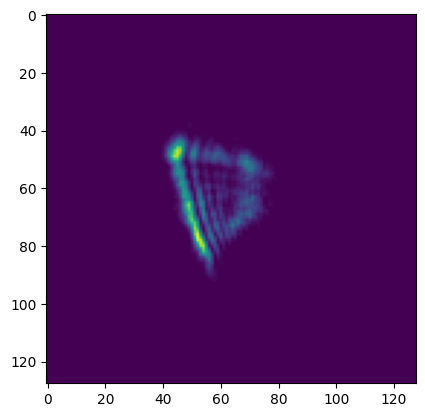

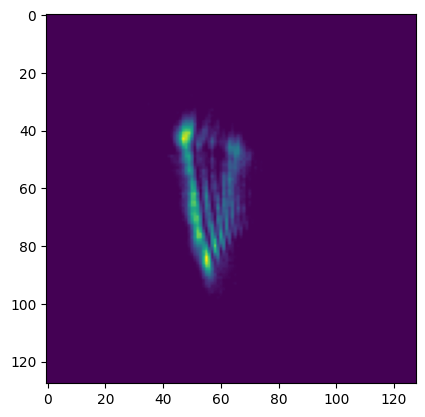

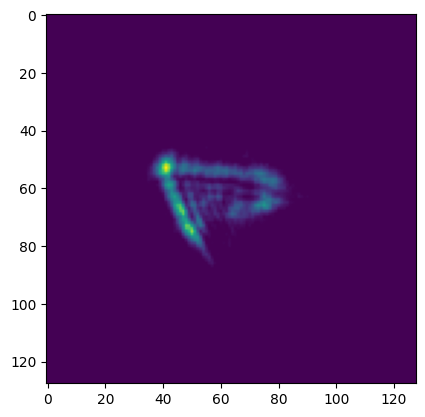

In [22]:
psfm = [None] * n_bias  # measured psf 
psfi = [None] * n_bias  # psf intensity
bg = 200  # camera's background
for i in range(n_bias):
    slm.setRO(i)
    psfm[i] = cam.snap()
    psfm[i] = (psfm[i] - bg) * (psfm[i] > bg)
    psfm[i] = cp.array(psfm[i])
    psfi[i] = psfm[i] + 0j
    plt.figure()
    if xp == cp:
        plt.imshow((psfm[i][int(N / 2 - 1):int(3 * N / 2 - 1), int(N / 2 - 1):int(3 * N / 2 - 1)]).get())
    else:
        plt.imshow(psfm[i][int(N / 2 - 1):int(3 * N / 2 - 1), int(N / 2 - 1):int(3 * N / 2 - 1)])

In [23]:
# for the starting test aberration
ri2 = (-18 * Z11 + 5 * Z22 - 7 * Z31 + 11 * Z3_3) * circ

Work out measured PSFs for the 3 applied masks

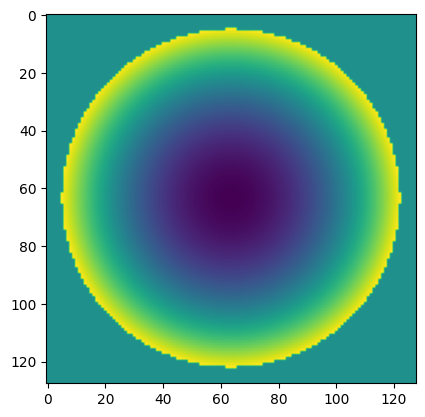

In [24]:
# plt.figure(100)
# if xp == cp:
#     plt.imshow((xp.angle(xp.exp(1j * ri))).get())
# else:
#     plt.imshow(xp.angle(xp.exp(1j * ri)))
# plt.title('Random target phase')

# sumc = xp.sum(circ)
# piston = xp.sum(xp.sum(ri * circ)) / sumc
# diff = (ri-piston) * circ
# rms = xp.sqrt(xp.sum(diff ** 2) / sumc)
# # imshow(diff.*circ,[])
# # text(0,-10,sprintf('max-min=%f, rms=%f, rmswaves=%f',max(diff(:))-min(diff(:)),rms,rms/2/pi))

# plt.figure(101)
# hlx = theta * circ  # helical wavefront
# if xp == cp:
#     plt.imshow(hlx.get())
# else:
#     plt.imshow(hlx)
# plt.title('Phase singularity')

plt.figure(102)
defocus = 2 * Z20
asti1 = 5 * Z22
asti2 = 5 * Z2_2
sph = 5 * Z40
bias = [0, defocus, -defocus, asti1, -asti1]
# bias = [0, defocus, asti1, -asti1]
# bias = [0, sph, -sph]
if xp == cp:
    plt.imshow(defocus.get())
else:
    plt.imshow(defocus)
# plt.title('Defocus')

# #% ampl=circ
# #% ampl=circ.*(1+x/3);  % a tilt in intensity accross the pupil
# ampl = circ * xp.exp(-((x - 0.25) ** 2 + 2 * y ** 2) / 2 / 1 ** 2)  # funny gaussian illumination to simulater a laser beam scenario; sigma=1

## Iteration loop to correct aberrations

In [25]:
cumphase = xp.zeros((N, N))
Q = circ * xp.exp(1j * ri2)

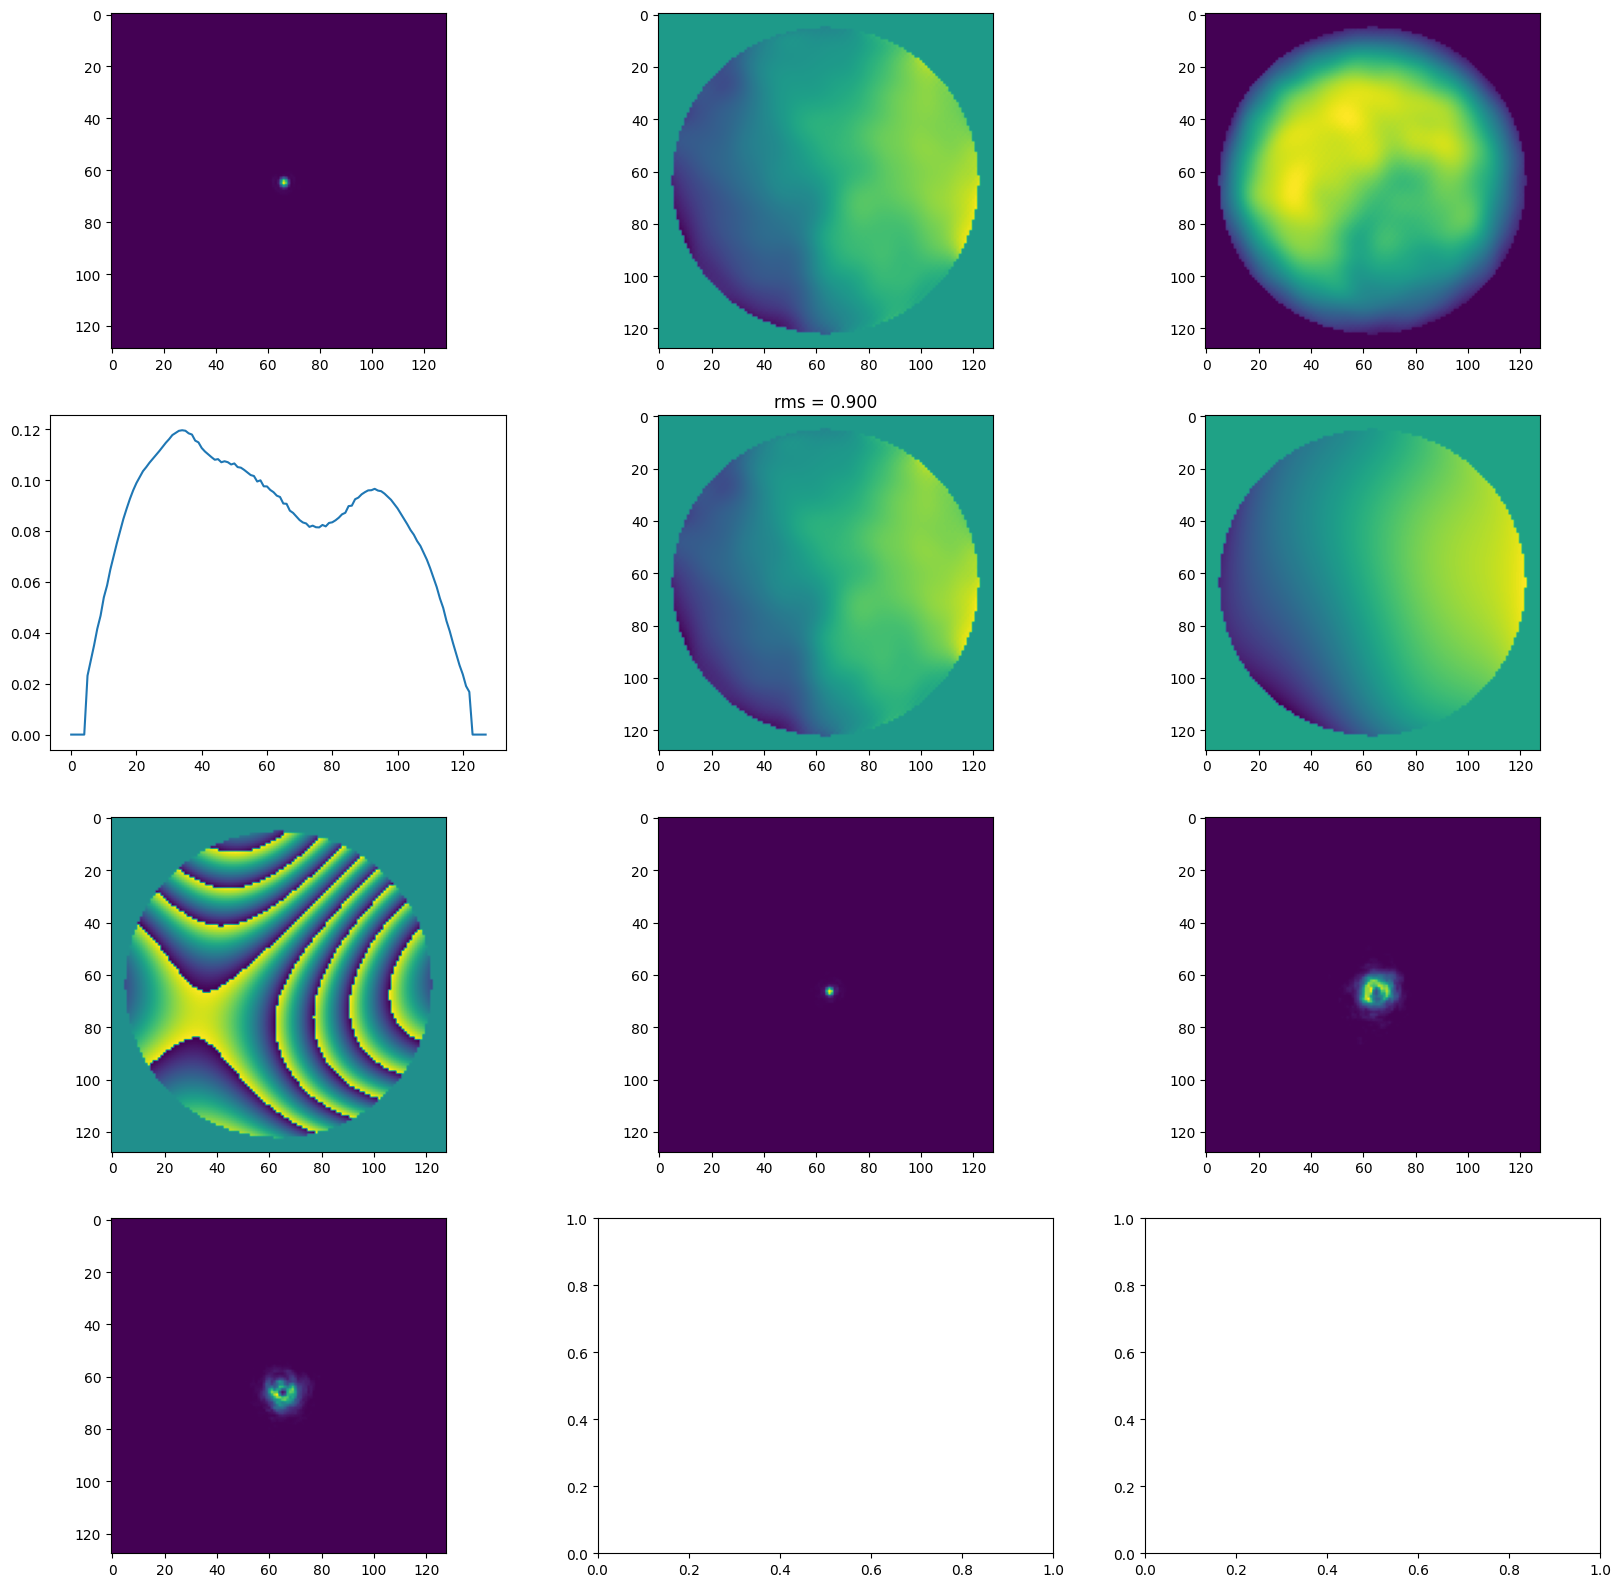

Elapsed time: 245.86889052391052s


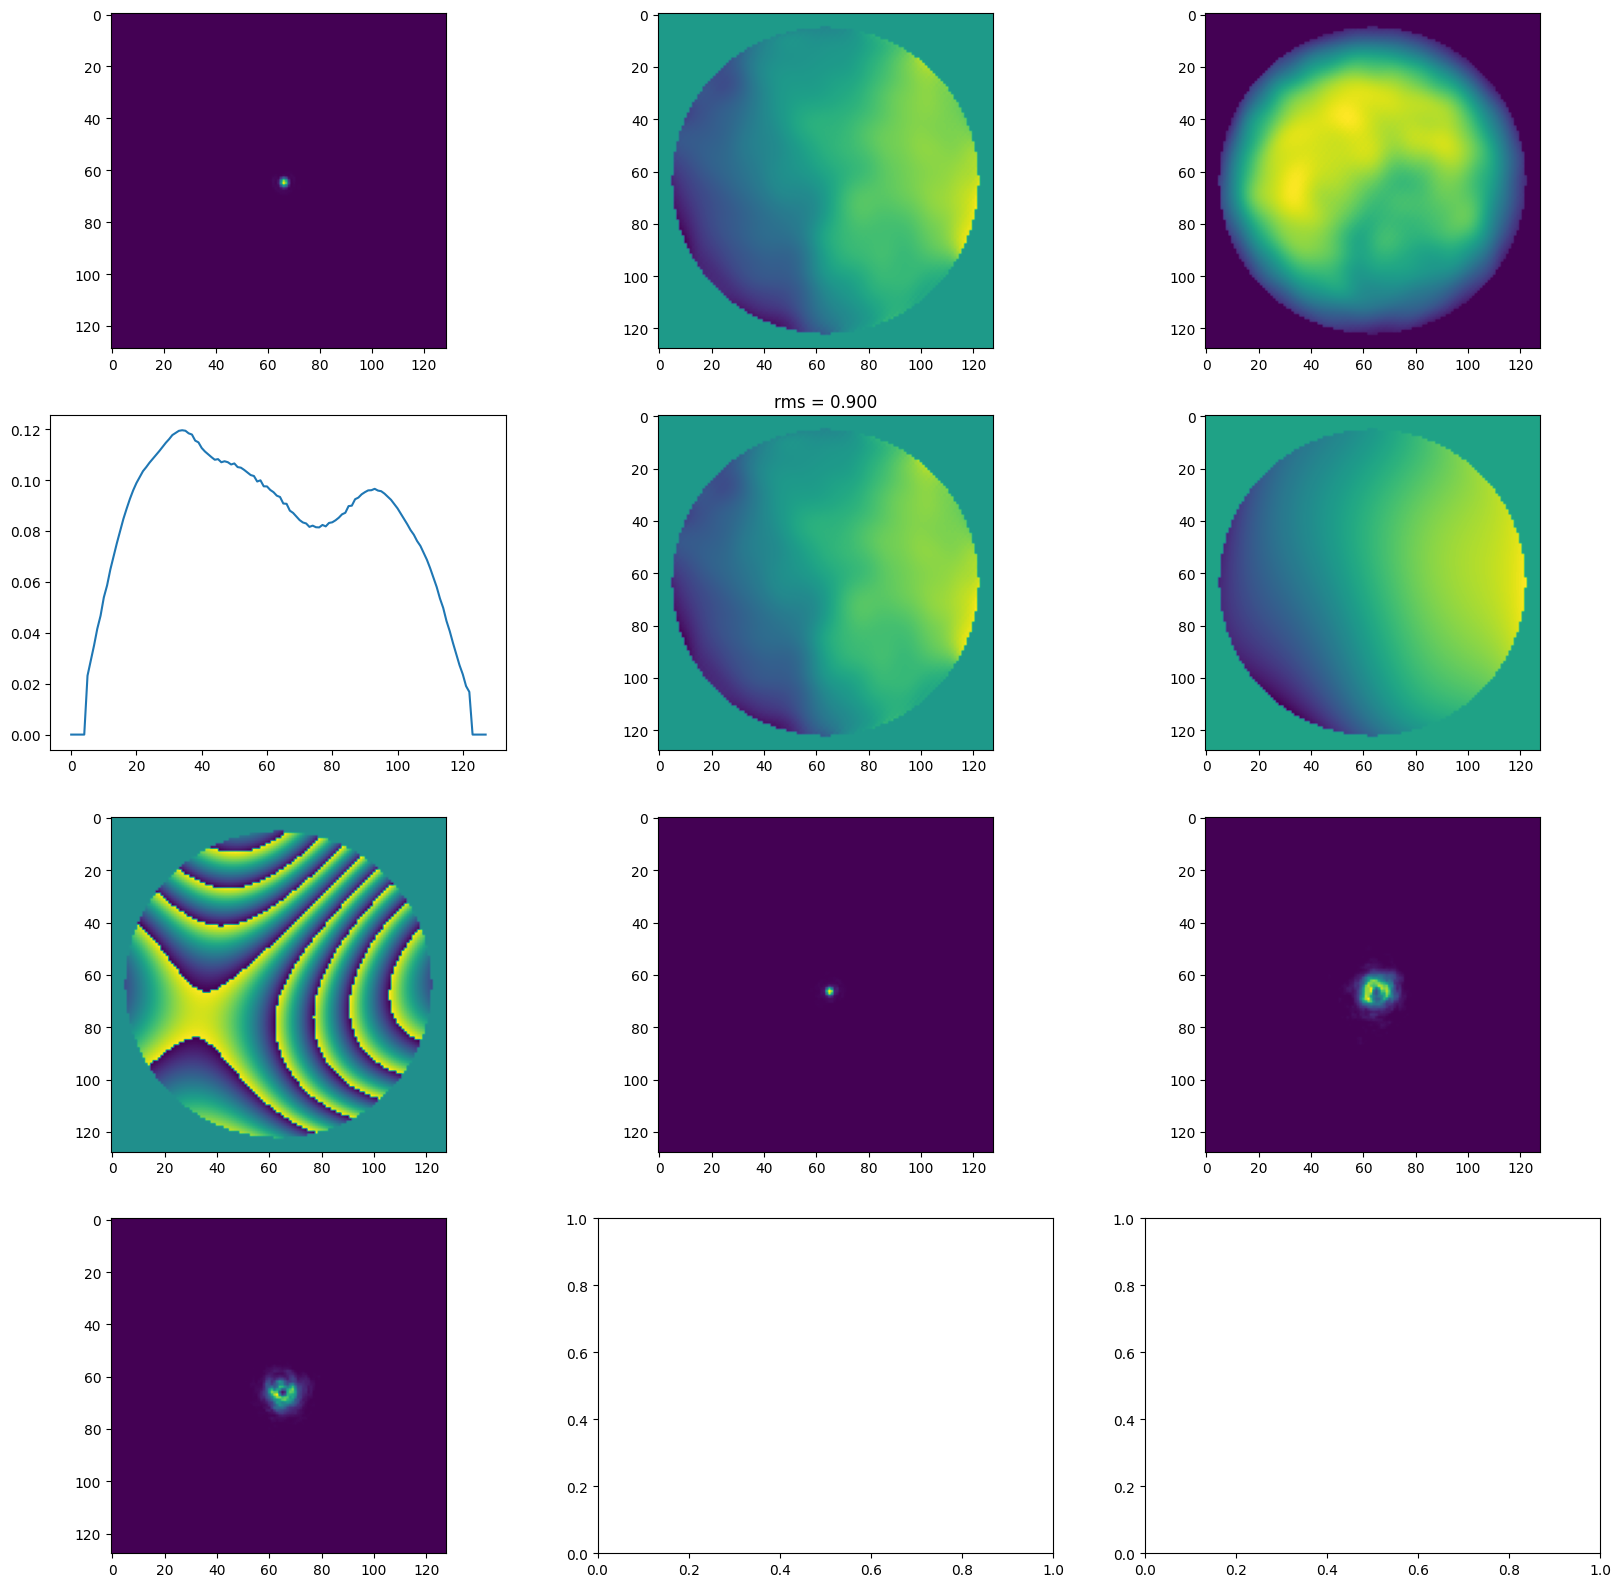

In [26]:
show_ani = True
if show_ani:
    f = plt.figure(figsize=(20,20))

    axes = []
    for i in range(12):
        axes.append(f.add_subplot(4,3,i+1))

def show_animation(k, img, title=None):
    if show_ani:
        axes[k].clear()
        if xp == cp:
            s = axes[k].imshow(img.get())
        else:
            s = axes[k].imshow(img)
        if not title is None:
            axes[k].set_title(title)
        if k == (6 + n_bias):
            display.clear_output(wait=True)
            display.display(axes[k].get_figure())
#             display.display([axis.get_figure() for axis in axes])

t0 = time.time()
nits = 1
n = 40
sumc = xp.sum(circ)
qq = [None] * n_bias
QQ = [None] * n_bias



while nits < 501:
    for ii in range(n_bias):
        qq[ii] = xp.fft.fftshift(xp.fft.fft2(Q * xp.exp(1j * bias[ii]), (2 * N, 2 * N)))
    q1s = qq[0][int(1*N/2-1):int(3*N/2), int(1*N/2-1):int(3*N/2)]
    
    if xp.mod(nits, n) == 0:
        show_animation(0, abs(q1s) ** 2)
        
    Q = 0
    for i in range(n_bias):
        QQ[i] = xp.fft.ifft2(xp.fft.fftshift(xp.sqrt(psfi[i]) * xp.exp(1j * xp.angle(qq[i])))) 
        QQ[i][:N, :N] = QQ[i][:N, :N] * circ * xp.exp(-1j * bias[i])
        Q = Q + QQ[i][:N, :N]

    if xp.mod(nits, n) == 0:
        show_animation(1,xp.angle(Q))


#     if xp.mod(nits,n) == 0:
# #         show_animation(2, diff * circ)
#         diff = xp.angle(Q * xp.exp(-1j * ri))
#         piston = xp.sum(diff * circ) / sumc
#         diff = (diff-piston) * circ
#         rms= xp.sqrt(xp.sum(diff ** 2) / sumc)
#         show_animation(2, diff)

        show_animation(2, abs(Q))

        if show_ani:
            axes[3].clear()
            if xp == cp:
                axes[3].plot(xp.squeeze(abs(Q.get()[N//2,:])))
            else:
                axes[3].plot(xp.squeeze(abs(Q[N//2,:])))
#             display.clear_output(wait=True)
#             display.display(axes[4].get_figure())

    # Constrain intensity in pupil to have slowly varying values by fitting to Zernike polynomials, up to radial order
    # 4 to help with gaussian illumination
    Qa = abs(Q)
    Qb = xp.sum(Qa * Z00) * Z00
    z_a_i = [Z11, Z1_1, Z20, Z22, Z2_2, Z31, Z3_1, Z40, Z42, Z4_2, Z44, Z4_4]  # Zernike aberration for intensity
    for i in z_a_i:
        Qb = Qb + xp.sum(Qa * i) * i

    Qc = xp.angle(Q)
    Q = Qb * xp.exp(1j * Qc) / sumc
    if xp.mod(nits, n) == 0:
        q = xp.angle(Q)
        q[N//2:, :] = xp.unwrap(q[N//2:, :], axis=0)
        q = xp.flipud(q)
        q[N//2:, :] = xp.unwrap(q[N//2:, :], axis=0)
        q[:, N//2:] = xp.unwrap(q[:, N//2:], axis=1)
        q = xp.fliplr(q)
        q[:, N//2:] = xp.unwrap(q[:, N//2:], axis=1)
        q = xp.flipud(xp.fliplr(q))
#         show_animation(5,xp.angle(xp.exp(1j * ri)))
    #         plt.text(0, -10, 'nits=%d , rms=%f, rmswaves=%f' % (nits, rms, rms / 2 / xp.pi))

        diff = q
        piston = xp.sum(diff * circ)/sumc
        diff = (diff-piston) * circ
        rms = xp.sqrt(xp.sum(diff ** 2) / sumc)
        show_animation(4, diff, f'rms = {rms:.3f}')
    #         plt.text(0, -10, 'nits=%d , rms=%f, rmswaves=%f' % (nits, rms, rms / 2 / xp.pi))

        Qc = q

        # Constrain phase in pupil to have slowly varying values by fitting to Zernike
        Qd = xp.sum(Qc * Z00) * Z00
        z_a_p = [Z11, Z1_1, Z20, Z22, Z2_2, Z31, Z3_1, Z33, Z3_3, Z40, Z42, Z4_2, Z44, Z4_4, Z51, Z5_1, Z53, Z5_3, Z55,Z5_5]  # Zernike aberration for phase
        for i in z_a_p:
            Qd = Qd + xp.sum(Qc * i) * i
        Qd=Qd/normval

        fac = 1
        Q = abs(Q) * xp.exp(1j * Qd * (1-1 / fac))
        # Q = abs(Q).*exp(1i*Qd)
        show_animation(5, Qd)
    # %         def = 0.9 * def;

        cumphase = cumphase + Qd / fac
        show_animation(6, xp.angle(xp.exp(1j * cumphase)))

        
        if xp == cp:
            abb = cpndimage.zoom(cumphase, int(MAG * slm.xpix / N), order=0)
        else:
            abb = scipy.ndimage.zoom(cumphase, int(MAG * slm.xpix / N), order=0)

        slm_offs = (abb.shape[0] - 2048) // 2
        slm_abb = abb[slm_offs:slm_offs + 2048, slm_offs:slm_offs + 2048]
        cumphase_interleaved = slm_abb[2048 - xp.array(slm.xv, dtype=int), xp.array(slm.yv, dtype=int)]

        for i in range(beams):
            Tau[i, :, :] = xSLM * xpSLM + ySLM * ypSLM - cumphase_interleaved
        G = xp.exp(1j * (Tau + Psi))  # calculate the terms needed for summation
        Phi = np.pi * (xp.real(G) < 0) * circD

        for k in range(n_bias):
            if xp == cp:
                img[k] = Phi[k].get()
            else:
                img[k] = Phi[k]
            hex_bits[k] = np.packbits(img[k].astype('int'), bitorder='little')
            timestamp = time.strftime("%y%m%d_%H%M%S", time.localtime())
        
        har.updateBp(hex_bits, f'iter{nits}_{timestamp}')
            

        for i in range(n_bias):
            slm.setRO(i)
            psfm[i] = cam.snap()
            psfm[i] = (psfm[i] - bg) * (psfm[i] > bg)
            psfm[i] = cp.array(psfm[i])
            psfi[i] = psfm[i] + 0j
            show_animation(7+i,psfm[i][int(N / 2 - 1):int(3 * N / 2 - 1), int(N / 2 - 1):int(3 * N / 2 - 1)])
            
    nits = nits + 1

print(f'Elapsed time: {time.time() - t0}s')

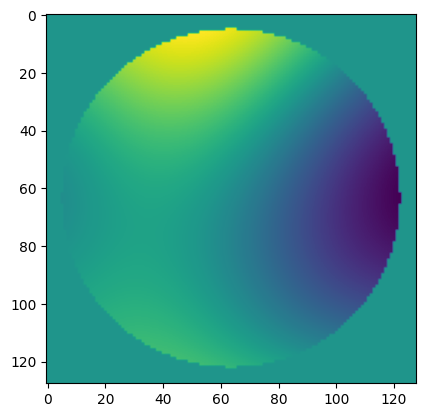

In [27]:
p0 = cumphase.get()
plt.imshow(p0)

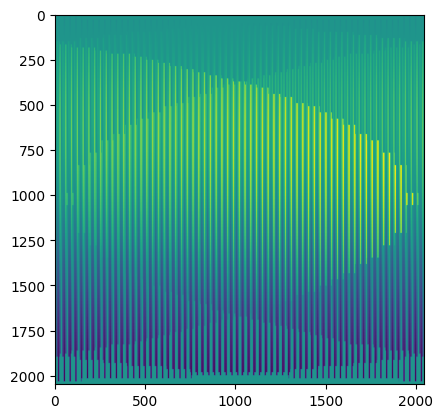

In [28]:
plt.imshow(cumphase_interleaved.get())

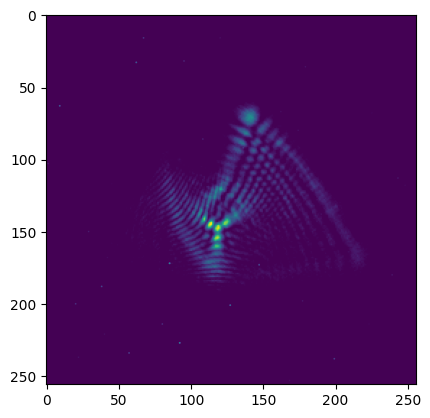

In [363]:
plt.imshow((p0 - 250) * (p0 > 250))

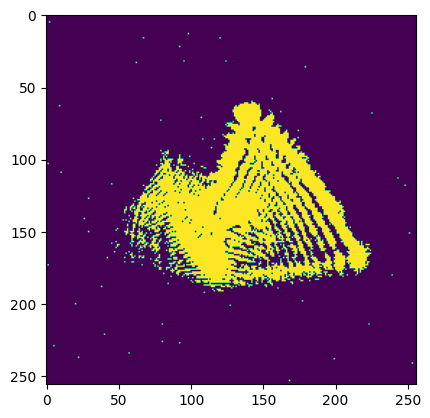

In [369]:
plt.imshow(p0 > 250)

In [350]:
psfm[2].max()

array(4184, dtype=uint16)

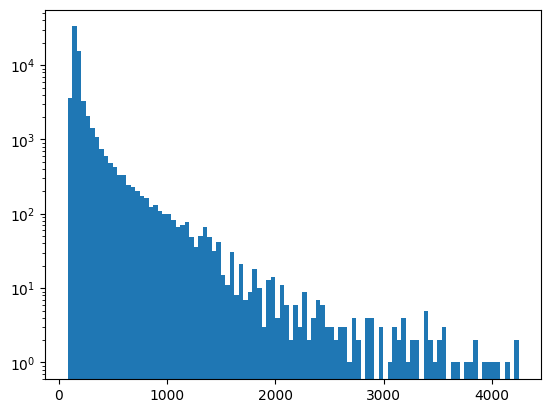

In [451]:
h = plt.hist(p0.flatten(), log=True, bins=100)

(256, 256)

In [1]:
plt.figure()
if xp == cp:
#     plt.imshow(xp.angle(xp.exp(1j * (cumphase))).get())
    plt.imshow(cumphase.get())
# plt.figure()
# if xp == cp:
#     plt.imshow((xp.angle(xp.exp(1j * cumphase))).get())

NameError: name 'plt' is not defined

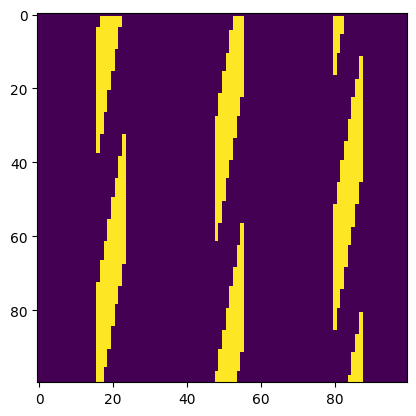

In [1155]:
plt.imshow(Phi[0].get()[:100, :100])

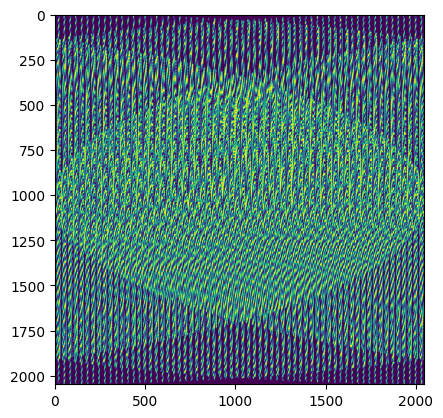

In [1201]:
plt.imshow(Phi[0].get())

In [872]:
print(rms)

17.9708566642901


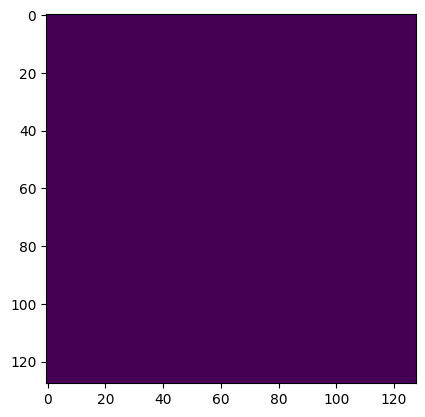

In [1144]:
plt.figure()
if xp == cp:
    plt.imshow((xp.angle(xp.exp(1j * cumphase))).get())

Text(0.5, 1.0, 'Random target phase')

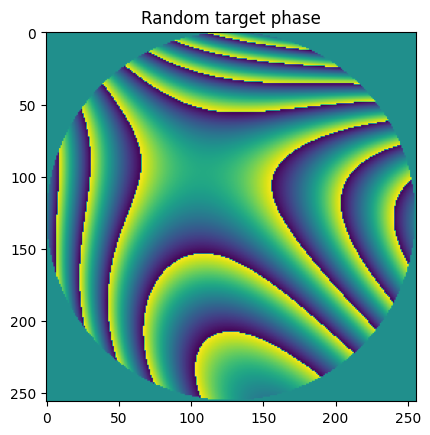

In [1191]:
plt.figure(100)
if xp == cp:
    plt.imshow(xp.angle(xp.exp(1j * (ri))).get())
else:
    plt.imshow(xp.angle(xp.exp(1j * (ri))))
plt.title('Random target phase')

In [1192]:
# zs = xp.zeros((1,21))
# Qc = cumphase

# # Constrain phase in pupil to have slowly varying values by fitting to Zernike
# Z_list = [Z00, Z11, Z1_1, Z20, Z22, Z2_2, Z31, Z3_1, Z33, Z3_3, Z40, Z42, Z4_2, Z44, Z4_4, Z51, Z5_1, Z53, Z5_3, Z55, Z5_5]

# for i in range(21):
#     zs[0, i] = xp.sum(Qc * Z_list[i])
# zs = zs/normval

Tried to make the retrived phase bianary, but failed. The PSF is too good to believe.

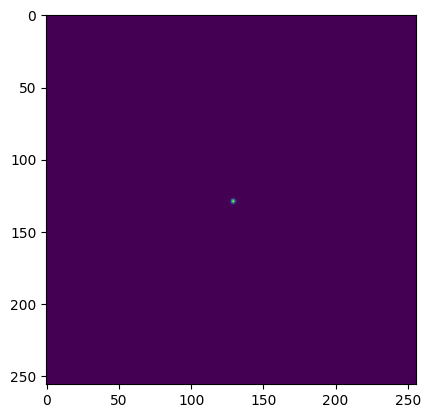

In [1193]:
plt.figure()
p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * (ri-cumphase)), (2*N, 2*N)))
p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
p1i_n = (xp.random.poisson(p1i) - bg) * G
psf_test = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]
if xp == cp:
    plt.imshow(abs(psf_test).get())
else:
    plt.imshow(abs(psf_test))

In [757]:
plt.figure()
p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * (cumphase)), (2*N, 2*N)))
p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
p1i_n = (xp.random.poisson(p1i) - bg) * G
psf_test = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]
if xp == cp:
    plt.imshow(abs(psf_test).get())
else:
    plt.imshow(abs(psf_test))

NameError: name 'ampl' is not defined

<Figure size 640x480 with 0 Axes>

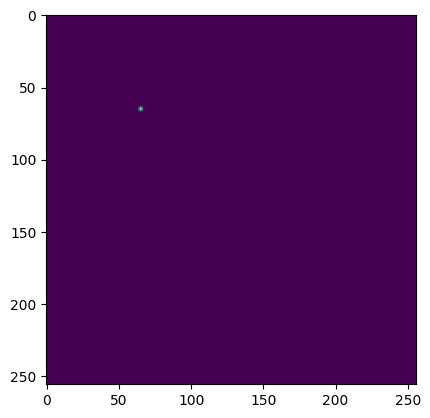

In [1195]:
plt.figure()
p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * (ri-bi_phi)), (2*N, 2*N)))
p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
p1i_n = (xp.random.poisson(p1i) - bg) * G
psf_test = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]
if xp == cp:
    plt.imshow(abs(psf_test).get())
else:
    plt.imshow(abs(psf_test))

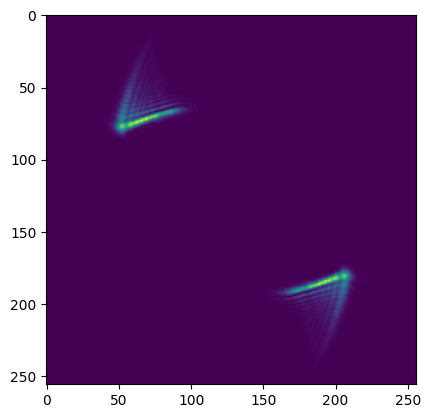

In [1196]:
plt.figure()
p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * (bi_phi)), (2*N, 2*N)))
p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
p1i_n = (xp.random.poisson(p1i) - bg) * G
psf_test = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]
if xp == cp:
    plt.imshow(abs(psf_test).get())
else:
    plt.imshow(abs(psf_test))